# R Car analysis tools

### This notebook contains some recipes to obtain the results reported in Rosales-Guzmán et al., ()

# Contents

[MCMC to the $V^2$](#mcmc_disk)

[Molsphere model to the $V^2$](#mcmc_molsphere)

[Bootstrap](#bootstrap)

<a id='top'></a> 

### Required packages (Python > 3.0):  
<nav>
<a href="https://www.astropy.org">Astropy</a>  
    
<a href="https://corner.readthedocs.io/en/latest/install/">corner</a> 
    
<a href="https://emcee.readthedocs.io/en/stable/user/install/">emcee</a> 
    
<a href="https://lmfit.github.io/lmfit-py/">lmfit</a>  
    
<a href="https://matplotlib.org">matplotlib</a>  
    
<a href="https://numpy.org">numpy</a>  
    
<a href="https://scipy.org/install/">scipy</a>  
    
<a href="https://scikit-learn.org/stable/install.html">sklearn</a>  
    
</nav>  

`oitools.py (provided)`

In [2]:
### Author: Abel Rosales-Guzman
###Load all the packages
from astropy.modeling import models 
import astropy.io.fits as pyfits
from astropy import constants as const 
from astropy import units as u 
import corner  
import datetime
import emcee
from lmfit import Model, Parameters, minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from multiprocessing import Pool
import numpy as np
import oitools
import os 
import scipy.special as sp
from sklearn.utils import resample

### Fitting the V$^2$ using MCMC in one spectral channel across the pseudo-continuum (example at 2.228 $\mu$m) 

<a id='mcmc_disk'></a> 

In [3]:
### MCMC functions 
def mas2rad(x_mas):
    x_rad = 4.847309743e-9 * x_mas
    return x_rad


def rad2mas(x_rad):
    x_mas = x_rad/4.847309743e-9
    return x_mas

def disk(u, v, diam, Fr):
    """
    diam = angular diameter in mas
    Fr = Scaling factor that accounts for the over-resolved flux   
    """
    diam = mas2rad(diam)
    r = np.sqrt(u**2 + v**2)
    v_disk = 2 * (sp.j1(np.pi * diam * r) / (np.pi * diam * r))

    return Fr*(v_disk)**2

def lnprior(theta):
    #flat prior, probability is uniform inside a given range, and zero outside
    if (1. < theta[0] < 30.) and (0. < theta[1] < 2.): #and (0. < theta[2] < 3.) : 
        return 0.0
    return -np.inf

def lnlike(theta, u, v, vis2, vis2err):
    diam = theta[0]
    Fr = theta[1]
    vis2model = disk(u, v, diam, Fr)
    chi2 =-0.5*np.sum((vis2-vis2model)**2/(vis2err)**2)
    return chi2

def lnprob(theta, u, v, vis2, vis2err):
    lp = lnprior(theta)
    if lp == -np.inf:
        return lp 
    return lp + lnlike(theta, u, v, vis2, vis2err)

100%|██████████| 150/150 [00:01<00:00, 139.68it/s]


Best Values
Theta_UD = 16.67 +- 0.06 0.06 mas
F_r = 0.963 +- 0.005 0.005


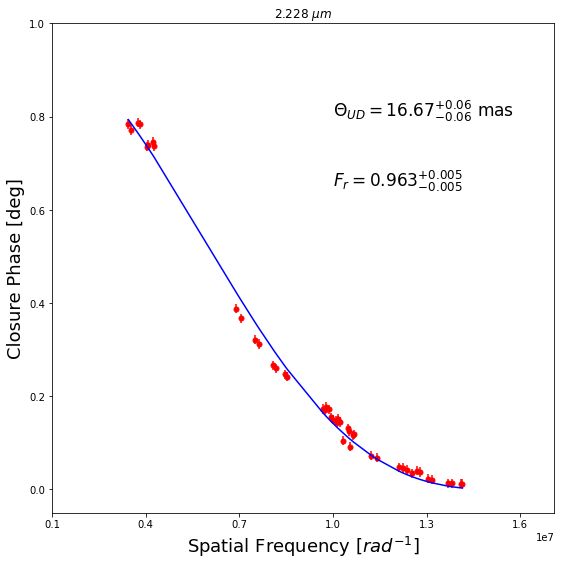

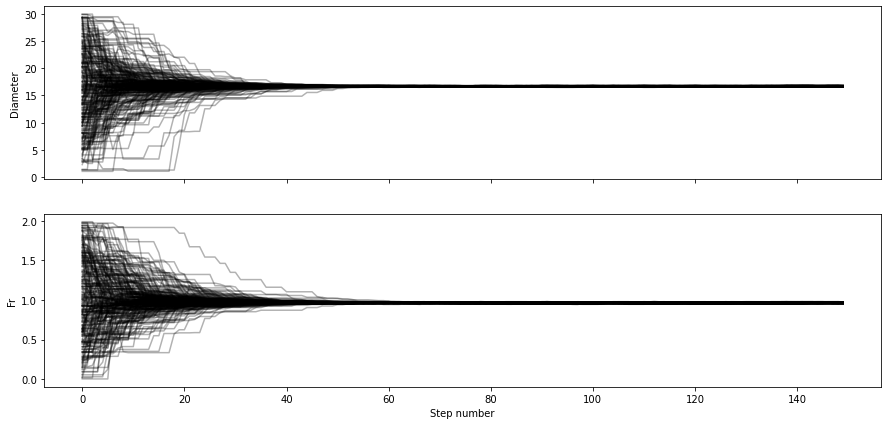

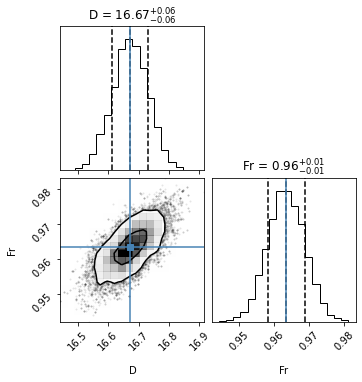

In [47]:
fits_f='phasediff_18_January_a200_COMB_RCar_cont_2.228m.fits'

##############Automatic from here##########
oidata = pyfits.open(fits_f)
oi_wave = oidata['OI_WAVELENGTH'].data
oi_vis2 = oidata['OI_VIS2'].data

waves = oi_wave['EFF_WAVE']
vis2 = oi_vis2['VIS2DATA']
vis2_err = oi_vis2['VIS2ERR']

vis2_err2 = np.full(vis2.shape, 0.01)
u = oi_vis2['UCOORD']
v = oi_vis2['VCOORD']

nvis = vis2.shape[0]
ndim = 2
nwalkers = 250
pos1 = np.random.uniform(1., 30., size=nwalkers)
pos2 = np.random.uniform(0., 2., size=nwalkers)


fig2, ax2 = plt.subplots(ncols=1,nrows=1, figsize=(9,9))

spf_u = u/waves[0]
spf_v = v/waves[0]
bssl = np.sqrt(spf_u**2+spf_v**2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(spf_u, spf_v, vis2, vis2_err2))
steps = 150
pos = np.array([pos1, pos2]).T

sampler.run_mcmc(pos,steps, progress = True)
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=70, flat=True)
fig1, _axs1 = plt.subplots(nrows=2, ncols=1, figsize=(15,7), sharex=True)
axs1 = _axs1.flatten()
axs1[1].set_xlabel('Step number')
axs1[0].set_ylabel('Diameter')
axs1[1].set_ylabel('Fr')

inds = np.random.randint(len(flat_samples), size=50)
for i in range(ndim):
    axs1[i].plot(samples[:, :, i], "k", alpha=0.3)

######## Plots ###### 
diam_mcmc, Fr_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(flat_samples, [16, 50, 84], axis=0)))

fig3 = corner.corner(flat_samples, labels=['D', 'Fr'], show_titles=True, title_fmt='0.2f',
              levels=(1 - np.exp(-0.5), 1 - np.exp(-2.0)),
           truths=[diam_mcmc[0], Fr_mcmc[0]], quantiles=[0.16, 0.5, 0.84],
               title_kwargs={'fontsize': 12})
print('Best Values')
print('Theta_UD = {:.2f} +- {:.2f} {:.2f} mas'.format(diam_mcmc[0], diam_mcmc[1], diam_mcmc[2]))
print('F_r = {:.3f} +- {:.3f} {:.3f}'.format(Fr_mcmc[0], Fr_mcmc[1], Fr_mcmc[2]))

iind1 = np.argsort(bssl)
ax2.errorbar(bssl, vis2, yerr=vis2_err2, fmt='o', ms=5, label='Data', c='red')
########
ax2.plot(bssl[iind1], disk(spf_u, spf_v, diam_mcmc[0], Fr_mcmc[0])[iind1], label='Model', c='blue', zorder=500)
ax2.text(1.0e7, 0.8, r'$\Theta_{{UD}}={:.2f}_{{-{:.2f}}}^{{+{:.2f}}}$ mas'.format(diam_mcmc[0], diam_mcmc[1], diam_mcmc[2]), fontsize=17)
ax2.text(1.0e7, 0.65, r'$F_r={:.3f}_{{-{:.3f}}}^{{+{:.3f}}}$'.format(Fr_mcmc[0], Fr_mcmc[1], Fr_mcmc[2]), fontsize=17)

ax2.set_ylim(-0.05, 1.0)
ax2.set_xlim(0.1e7, 1.71e7)
ax2.set_xticks(np.arange(0.1e7, 1.71e7, step=0.3e7))
ax2.set_title(r'{:.3f} $\mu m$'.format(waves[0]/1.e-6))
ax2.set_xlabel(r'Spatial Frequency [$rad^{-1}$]', fontsize=18)
ax2.set_ylabel('Closure Phase [deg]', fontsize=18)


plt.show()


[Go back to top](#top)

<a id='mcmc_molsphere'></a> 

### Example of the MOLsphere code for one spectral channel (2.2946 microns). See Rosales-Guzman et al., for a detailed description of the models. 

In [50]:
###### Visibility and Intensity Functions ######

def img_grid(npixels, pixelscale):
	size = npixels*pixelscale 
	x = np.linspace(-0.5*size, 0.5*size, npixels)
	y = np.linspace(-0.5*size, 0.5*size, npixels)
	return x, y


def SLModel(Tl, Rl, tau, Fr):
	"""
    This function calculates the V^2 corresponding to the MOLsphere
    Tl, Rl = Temperature  and radius of the layer
	Ts, Rs = Temperature and radius of the star 
	tau =  optical dept of the molecular layer at a wavelength lamdbda
	r = radius to evaluate the model 
	Fr = Scaling factor to account for the over resolved component
    Wavelength is given in microns 
	"""
	npixels = 128  #px
	pixelscale = 0.46875 #[mas/px]
	x, y = img_grid(npixels, pixelscale)
	r=np.zeros([x.shape[0], y.shape[0]])
	for j in range(128): 
	    for k in range(128): 
	    	r[j,k]=np.sqrt(x[j]**2+y[k]**2)
	
	I2 = np.zeros([128,128])
	Rs = 5. # diameter of R Car = 10 mas, thus R = 5mas  
	Ts = 2800. # Kelvin, effective temperture of R Car
	wavelength = slm_wave
	bb_s = models.BlackBody(temperature=Ts*u.K)
	bb_L = models.BlackBody(temperature=Tl*u.K)
	
	B_s = bb_s(wavelength*u.micron)
	B_l = bb_L(wavelength*u.micron)
	# I = []
	for i in range(r.shape[0]):
		for j in range(r.shape[1]):
			if r[i,j] <= Rs:
				cos_beta1 = (1./Rl)*np.sqrt(Rl**2-r[i,j]**2)
				I2[i,j] = B_s.value*np.exp(-tau/cos_beta1) + B_l.value*(1-np.exp(-tau/cos_beta1))  
			elif (r[i,j] > Rs) and (r[i,j] < Rl): 
				cos_beta = np.sqrt(1-(r[i,j]/Rl)**2)
				I2[i,j] = B_l.value*(1-np.exp(-2*tau/cos_beta))  
			else: 
				I2[i,j] = 0.000
	##Adding the Over resolved component
	I3 = I2/np.sum(I2) 
	I3 = Fr*I3
	Fr_comp = 1.-Fr 
	[iind0, iind1] = np.where(I3 == 0)  
	px_zero = iind0.shape[0]   
	temp = Fr_comp/px_zero 
	I3[iind0, iind1] = temp 
	###Computing the V^2
	vis_synth, phi_synth, t3phi_synth = oitools.compute_obs(oi_data, I3, pixelscale, 6, 4)
	return (np.squeeze(vis_synth))**2

def I_SLModel(Tl, Rl, tau):
	"""
    This function calculates the intensity (I) of the MOLsphere
	Tl, Rl = Temperature  and radius of the layer
	Ts, Rs = Temperature and radius of the star 
	tau =  optical dept of the molecular layer at a wavelength lamdbda
	r = radius to evaluate the model 
	wavelength is given in microns 
	"""
	npixels = 128  #px
	pixelscale = 0.46875 #[mas/px]
	x, y = img_grid(npixels, pixelscale)
	r=np.zeros([x.shape[0], y.shape[0]])
	for j in range(128): 
	    for k in range(128): 
	    	r[j,k]=np.sqrt(x[j]**2+y[k]**2)
	I2 = np.zeros([128,128])
	Rs = 5. # diameter of R Car = 10 mas, thus R = 5mas  
	Ts = 2800. # Kelvin, effective temperature of R Car
	wavelength = slm_wave
	bb_s = models.BlackBody(temperature=Ts*u.K)
	bb_L = models.BlackBody(temperature=Tl*u.K)
	
	B_s = bb_s(wavelength*u.micron)
	B_l = bb_L(wavelength*u.micron)
	# I = []
	for i in range(r.shape[0]):
		for j in range(r.shape[1]):
			if r[i,j] <= Rs:
				cos_beta1 = (1./Rl)*np.sqrt(Rl**2-r[i,j]**2)
				# print(cos_beta)
				I2[i,j] = B_s.value*np.exp(-tau/cos_beta1) + B_l.value*(1-np.exp(-tau/cos_beta1))  
				# I2[i,j]=I
			elif (r[i,j] > Rs) and (r[i,j] <= Rl): 
				cos_beta = np.sqrt(1-(r[i,j]/Rl)**2)
				# print(r[i,j], cos_beta, Rl2)
				I2[i,j] = B_l.value*(1-np.exp(-2*tau/cos_beta))  
				# I2[i,j]=I
			else: 
				I2[i,j] = 0.000
	
	return I2  

In [28]:
###MCMC functions
def resid_flux(params, Flux, fluxerr):
    """
    Function used to fit the tau given Tl and Rl
    """
	pars = params.valuesdict()
	Tl = pars['Tl']
	Rl = pars['Rl']
	tau = pars['tau']
	temp_I = I_SLModel(Tl, Rl, tau)
	F_tau0 = flux_tau0_1[0] # Flux at zero optical depth (see Rodríguez-Coira et al., 2021)
	F_layer = np.sum(temp_I) # Flux of the layer 
	F_teor = F_layer/F_tau0 
	return (Flux-F_teor)/fluxerr

def lnprior(theta):
	#flat prior, probability is uniform inside a given range, and zero outside
	if (1000. < theta[0] < 2800.) and (5.1 < theta[1] < 20.) and (0.01 < theta[2] < 2.): 
		# print(theta)
		return 0.0
	return -np.inf

def lnlike(theta, vis2, vis2err):
	Tl = theta[0]
	Rl =theta[1]
	Fr = theta[2]
	# ndof = vis2.shape[0]
	# dim = len(theta)
	factor = 39. #ndof
	#####fitting the tau##########
	params = Parameters()
	params.add('tau', value=0.5, min=1.e-6, max=5.)
	params.add('Tl', value=Tl, vary=False)
	params.add('Rl', value=Rl, vary=False)
	result = minimize(resid_flux, params, args=(norm_spec[:,1][ind2], (np.array([0.05]))**2))
	taul = result.params['tau'].value
	Taus_err = result.params['tau'].stderr
	TChi2 = result.redchi
	if TChi2 < 3: ##keeping only the smallest Chi^2
		Tauss_chi2.append(TChi2)
		Tauss.append(taul)
		TRl.append(result.params['Rl'].value)
		TTl.append(result.params['Tl'].value)
		vis_synth2 = SLModel(Tl, Rl, taul, Fr)
	else: 
		Tauss_chi2.append(TChi2)
		Tauss.append(0.)
		TRl.append(result.params['Rl'].value)
		TTl.append(result.params['Tl'].value)
		tau_no=0.
		vis_synth2 = SLModel(Tl, Rl, tau_no, Fr)
	return ((-0.5*np.sum((vis2 - vis_synth2)**2/vis2err**2)/(factor)))   


def lnprob(theta, vis2, vis2err):
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	else:
		return lp + lnlike(theta, vis2, vis2err)

2.2946410354052205
2.294641013196623


100%|██████████| 1000/1000 [4:40:16<00:00, 16.82s/it] 


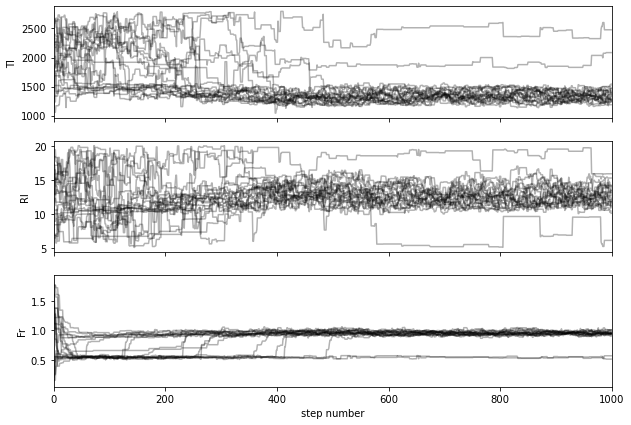

Tau
1.7735459930550008 0.4417837826432305 0.666409310755729
Samples to discard
200


<ipython-input-30-9d9a211fa08b>:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Best Values
T_l = 1334.031 +- 106.453 92.060 K
R_l = 12.489 +- 1.577 1.239 mas
Tau_l = 1.774 +- 0.442 0.666
Fr = 0.955 +- 0.033 0.030
[0.0059141]


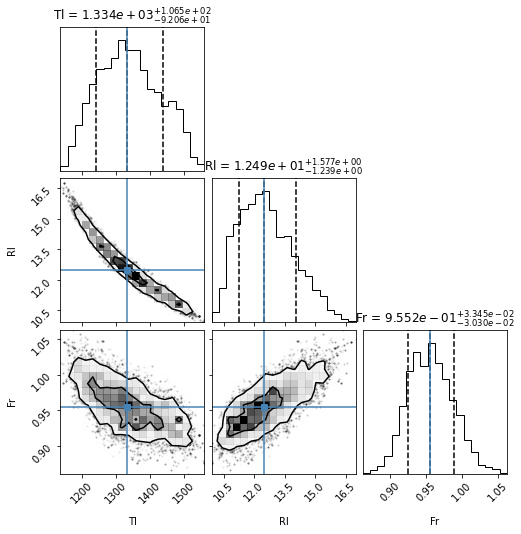

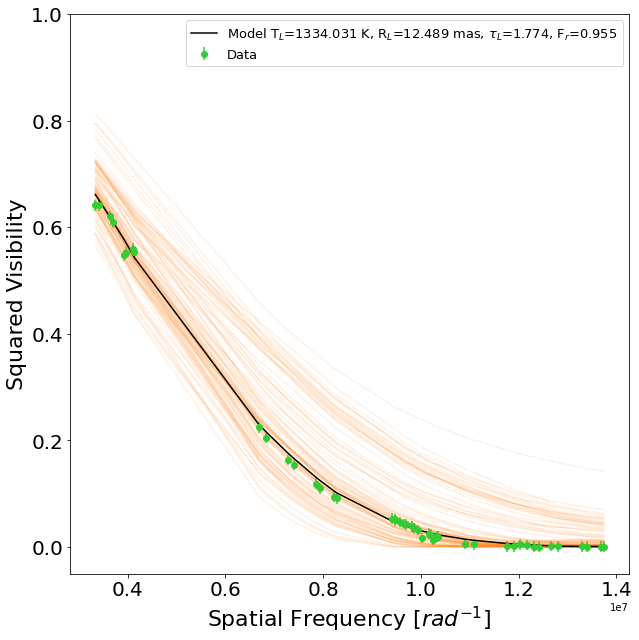

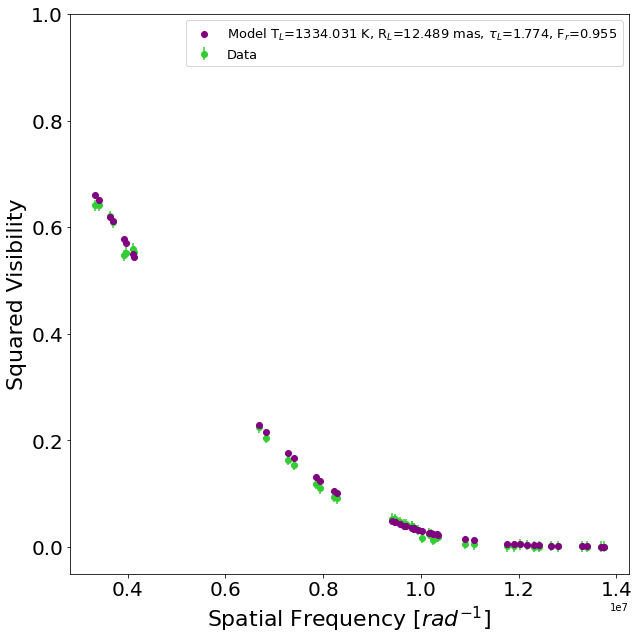

In [30]:
if __name__=="__main__":
    #Estimated time for the execution of this cell using 1000 iterations: 4Hrs 40min
    norm_spec = np.genfromtxt('RCar_normspec_final_Jan.txt') #January #norm_spec[:,0]-> wavelength, norm_spec[:,1]- > Flux 
    oi_data = 'phasediff_18_January_COMB_RCar_CO_2.2946m.fits'

    specr_min = [2.2945e-6] #In meters first because the wavelengths inside the fits files are provided in meters
    specr_max = [2.2947e-6] 
    ################
    wave_range = [2.2945e-6, 2.2947e-6] #### Wavelength range that you want to fit
    flux_tau0_1 = [0.0013643644802048] # Calculated flux if tau = 0 (See Eq. 7 from Rodriguez-Coira et al., 2021)
    lambda_co=[2.2946] #microns, the center of the band head

    ################Automatic from here#############
    oidata = pyfits.open(oi_data)
    oi_wave = oidata['OI_WAVELENGTH'].data
    oi_vis2 = oidata['OI_VIS2'].data
    oi_t3 = oidata['OI_T3'].data
    waves = oi_wave['EFF_WAVE']
    vis2 = oi_vis2['VIS2DATA']
    vis2_err = oi_vis2['VIS2ERR']
    t3 = oi_t3['T3PHI']
    t3_err = oi_t3['T3PHIERR']

    u_coord = oi_vis2['UCOORD']
    v_coord = oi_vis2['VCOORD']
    u1 = oi_t3['U1COORD']
    u2 = oi_t3['U2COORD']
    v1 = oi_t3['V1COORD']
    v2 = oi_t3['V2COORD']

    nvis = vis2.shape[0]
    nt3phi = t3.shape[0]
    vis2_err2 = np.full(vis2.shape[0], 0.01)

    ##########
    # To compute the UV coordinates of the closure phases:
    uv_cp = np.zeros([u1.shape[0]])
    u_cp = np.zeros([u1.shape[0]])
    v_cp = np.zeros([u1.shape[0]])
    u3 = -1.0 * (u1 + u2)
    v3 = -1.0 * (v1 + v2)

    for j in range(u1.shape[0]):
        uv1 = np.sqrt((u1[j]) ** 2 + (v1[j]) ** 2)
        uv2 = np.sqrt((u2[j]) ** 2 + (v2[j]) ** 2)
        uv3 = np.sqrt((u3[j]) ** 2 + (v3[j]) ** 2)
        if uv1 >= uv2 and uv1 >= uv3:
            uv_cp[j] = uv1
            u_cp[j] = u1[j]
            v_cp[j] = v1[j]
        elif uv2 >= uv1 and uv2 >= uv3:
            uv_cp[j] = uv2
            u_cp[j] = u2[j]
            v_cp[j] = v2[j]
        elif uv3 >= uv1 and uv3 >= uv2:
            uv_cp[j] = uv3
            u_cp[j] = u3[j]
            v_cp[j] = v3[j]

    [ind] = np.where((waves >= wave_range[0]) & (waves <= wave_range[1]))
    slm_wave = waves[ind[0]]/1.e-6
    print(slm_wave)
    [ind2] = np.where((norm_spec[:,0] >= wave_range[0]/1.e-6) & (norm_spec[:,0] <= wave_range[1]/1.e-6)) ##index of the spectrum 
    spf_u = u_coord/waves[0]
    spf_v = v_coord/waves[0]
    bsl = np.sqrt(spf_u**2 + spf_v**2)
    print(norm_spec[:,0][ind2][0])
    Tauss = []
    Tauss_chi2=[]
    TRl=[]
    TTl=[]
    np.seterr(all='ignore')
    ndim = 3
    nwalkers = 20 #must be even 
    steps  = 1000 #1000

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(vis2, vis2_err2), threads=pool)

        pos0 = np.random.uniform(1000, 2800, size=nwalkers)
        pos1 = np.random.uniform(5.1, 20, size = nwalkers)
        pos2 = np.random.uniform(0.1, 2., size = nwalkers)
        pos = np.array([pos0, pos1, pos2]).T
        sampler.run_mcmc(pos, steps, progress=True)
    samples = sampler.get_chain() 

    fig, axes = plt.subplots(3, figsize=(10,7), sharex = True) 
    fig.patch.set_facecolor('white') 
    labels = ['Tl', 'Rl', 'Fr'] 
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:,:,i], 'k', alpha=0.3)
        ax.set_xlim(0, len(samples))
        # ax.set_ylim()
        ax.set_ylabel(labels[i]) 
    axes[-1].set_xlabel('step number'); 
    plt.savefig('Jan_Conv_TlRlFr_{:.4f}mic.png'.format(norm_spec[:,0][ind2][0]))
    plt.show()

    tauss1 = np.asarray(Tauss)  
    [iind11] = np.where((tauss1 > 2e-6) & (tauss1 < 4.8))  
    Taumcmc = np.percentile(tauss1[iind11], [16, 50, 84])
    q1 = np.diff(Taumcmc)
    print('Tau')
    print(Taumcmc[1], q1[0], q1[1])
    print('Samples to discard')
    discard = int(input())
    
    flat_samples = sampler.get_chain(discard=discard, flat=True, thin=1)	
    prob_dist = sampler.get_log_prob(discard=discard, flat=True, thin=1) 
    indd = np.where(prob_dist > -6.0) 
    fl_samples = np.squeeze(flat_samples[indd,:]) 
    Tl_mcmc, Rl_mcmc, Fr_mcmc= map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(fl_samples, [16, 50, 84], axis=0)))
    fig = corner.corner(fl_samples, labels=['Tl', 'Rl', 'Fr'], show_titles=True, title_fmt='0.3e', 
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2.0)), 
                    truths=[Tl_mcmc[0], Rl_mcmc[0], Fr_mcmc[0]], quantiles=[0.16, 0.5, 0.84], 
                        title_kwargs={'fontsize': 12}) 
    fig.savefig('Jan_Corner_{:.4f}mic.png'.format(norm_spec[:,0][ind2][0]))
    fig.show() 

    print('Best Values')
    print('T_l = {:.3f} +- {:.3f} {:.3f} K'.format(Tl_mcmc[0], Tl_mcmc[1], Tl_mcmc[2]))
    print('R_l = {:.3f} +- {:.3f} {:.3f} mas'.format(Rl_mcmc[0], Rl_mcmc[1], Rl_mcmc[2]))
    print('Tau_l = {:.3f} +- {:.3f} {:.3f}'.format(Taumcmc[1], q1[0], q1[1]))
    print('Fr = {:.3f} +- {:.3f} {:.3f}'.format(Fr_mcmc[0], Fr_mcmc[1], Fr_mcmc[2]))
    print((np.sum(I_SLModel(Tl_mcmc[0], Rl_mcmc[0], Taumcmc[1]))/flux_tau0_1[0])-norm_spec[:,1][ind2])

    v2_model = SLModel(Tl_mcmc[0], Rl_mcmc[0], Taumcmc[1], Fr_mcmc[0])
    bsl_ord = np.argsort(bsl)
########Plots########
    plt.figure(figsize=(9,9))
    plt.xlabel(r'Spatial Frequency $[rad^{-1}]$', fontsize=22)
    plt.ylabel(r'Squared Visibility', fontsize=22)
    plt.ylim(-0.05, 1.)
    index = np.random.randint(len(samples), size=100)
    for inds in index:
        sampls=fl_samples[inds]
        plt.plot(bsl[bsl_ord], SLModel(sampls[0], sampls[1], tauss1[iind11][inds], sampls[2])[bsl_ord],'C1', alpha=0.1)
    plt.errorbar(bsl, vis2, yerr=vis2_err2, label='Data', fmt='o', color='limegreen')
    plt.plot(bsl[bsl_ord], v2_model[bsl_ord], c='k', 
            label=r'Model T$_L$={:.3f} K, R$_L$={:.3f} mas, $\tau_L$={:.3f}, F$_r$={:.3f}'.format(Tl_mcmc[0], Rl_mcmc[0], Taumcmc[1], Fr_mcmc[0]))
    plt.tick_params(axis='both', labelsize=20)
    plt.legend(fontsize=13)
    plt.tight_layout()
    
    plt.savefig('Jan_vis2spf_model_{:.4f}mic.png'.format(norm_spec[:,0][ind2][0]))
    plt.show()


    plt.figure(figsize=(9,9))
    plt.xlabel(r'Spatial Frequency $[rad^{-1}]$', fontsize=22)
    plt.ylabel(r'Squared Visibility', fontsize=22)
    plt.ylim(-0.05, 1.)
    index = np.random.randint(len(samples), size=100)
    plt.errorbar(bsl, vis2, yerr=vis2_err2, label='Data', fmt='o', color='limegreen')
    plt.scatter(bsl, v2_model, c='purple',
        label=r'Model T$_L$={:.3f} K, R$_L$={:.3f} mas, $\tau_L$={:.3f}, F$_r$={:.3f}'.format(Tl_mcmc[0], Rl_mcmc[0], Taumcmc[1], Fr_mcmc[0]),zorder=500)
    plt.tick_params(axis='both', labelsize=20)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig('Jan_V3_vis2spf_model_{:.4f}mic.png'.format(norm_spec[:,0][ind2][0]))
    plt.show()


[Go back to top](#top)

<a id='bootstrap'></a> 

### Bootstrapping example for one spectral channel across the pseudo-continuum (2.228 $\mu$m)

### This part of code opens one of our observations' .fits file. Then, using the sklearn package 'resample' we build the new data sets. See (Rosales-Guzman et al. () for more information) 

In [5]:
waves_cont = np.array([2.228])

month = ['January']
file = 'phasediff_18_'+month[0]+'_a200_COMB_RCar_cont_'+'{:.3f}'.format(waves_cont[0])+'m.fits'
path=''
directory = os.path.exists(path+'bt_method/'+'{:.3f}'.format(waves_cont[0]))
if directory == False:
    print('Creating directory')
    os.system('mkdir '+path+'bt_method/'+'{:.3f}'.format(waves_cont[0]))
oi_data=pyfits.open(file)
for k in range(50):
    oi_data.writeto(path+'bt_method/'+'{:.3f}'.format(waves_cont[0])+'/'+'bt{}_'.format(k)+file, overwrite=True)
    data= pyfits.open(path+'bt_method/'+'{:.3f}'.format(waves_cont[0])+'/'+'bt{}_'.format(k)+file, mode='update')
    av2=data['OI_VIS2'].data['VIS2DATA']
    at3=data['OI_T3'].data['T3PHI']
    ### We label each data point 
    numbers_v2=np.arange(av2.shape[0])
    numbers_t3=np.arange(at3.shape[0])
    ### Using the labels we create random samples of the data points allowing replace and keeping the total numer of points. 
    ### This method allows us to create as many data samples as we want. In our case we created 50  
    boot_v2 = resample(numbers_v2, replace=True, n_samples=numbers_v2.shape[0], random_state=k)
    boot_t3 = resample(numbers_t3, replace=True, n_samples=numbers_t3.shape[0], random_state=k)
    aa=np.array(boot_v2, dtype='int')
    bb=np.array(boot_t3, dtype='int')
        
    data['OI_VIS2'].data = data['OI_VIS2'].data[aa]
    data['OI_T3'].data = data['OI_T3'].data[bb]

    data.flush()
    data.close()

### Illustrative plots showing how the bootstrap method works
As this is only an illustrative example, we will plot 10 bootstrapped samples in order to better visualize the results

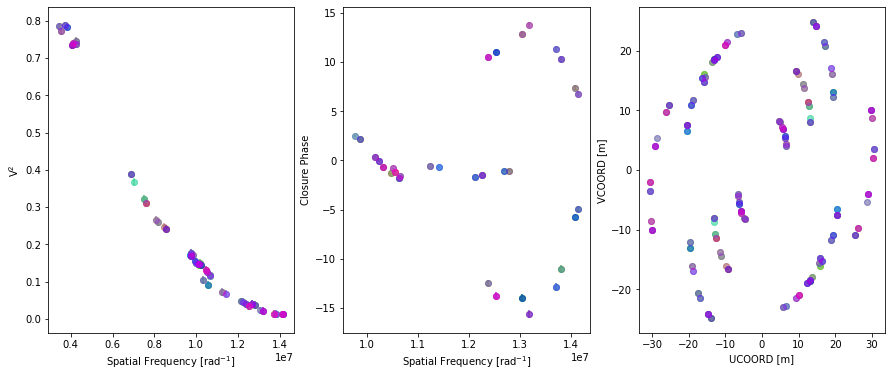

In [6]:
fig4, _axs4 = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
axs4 = _axs4.flatten()
colrs = plt.cm.gist_rainbow(np.linspace(0,1,10))
temp = np.random.randint(23)
axs4[0].set_xlabel(r'Spatial Frequency [rad$^{{-1}}$]')
axs4[0].set_ylabel(r'V$^2$')

axs4[1].set_xlabel(r'Spatial Frequency [rad$^{{-1}}$]')
axs4[1].set_ylabel(r'Closure Phase')

axs4[2].set_xlabel(r'UCOORD [m]')
axs4[2].set_ylabel(r'VCOORD [m]')

for k in range(10):
    ################Automatic from here#############
    oidata = pyfits.open('bt_method/2.228/bt{}_'.format(k)+file)
    oi_wave = oidata['OI_WAVELENGTH'].data
    oi_vis2 = oidata['OI_VIS2'].data
    oi_t3 = oidata['OI_T3'].data
    waves = oi_wave['EFF_WAVE']
    vis2 = oi_vis2['VIS2DATA']
    vis2_err = oi_vis2['VIS2ERR']
    t3 = oi_t3['T3PHI']
    t3_err = oi_t3['T3PHIERR']

    u_coord = oi_vis2['UCOORD']
    v_coord = oi_vis2['VCOORD']
    u1 = oi_t3['U1COORD']
    u2 = oi_t3['U2COORD']
    v1 = oi_t3['V1COORD']
    v2 = oi_t3['V2COORD']

    nvis = vis2.shape[0]
    nt3phi = t3.shape[0]
    vis2_err2 = np.full(vis2.shape[0], 0.01)

    ##########
    # To compute the UV coordinates of the closure phases:
    uv_cp = np.zeros([u1.shape[0]])
    u_cp = np.zeros([u1.shape[0]])
    v_cp = np.zeros([u1.shape[0]])
    u3 = -1.0 * (u1 + u2)
    v3 = -1.0 * (v1 + v2)

    for j in range(u1.shape[0]):
        uv1 = np.sqrt((u1[j]) ** 2 + (v1[j]) ** 2)
        uv2 = np.sqrt((u2[j]) ** 2 + (v2[j]) ** 2)
        uv3 = np.sqrt((u3[j]) ** 2 + (v3[j]) ** 2)
        if uv1 >= uv2 and uv1 >= uv3:
            uv_cp[j] = uv1
            u_cp[j] = u1[j]
            v_cp[j] = v1[j]
        elif uv2 >= uv1 and uv2 >= uv3:
            uv_cp[j] = uv2
            u_cp[j] = u2[j]
            v_cp[j] = v2[j]
        elif uv3 >= uv1 and uv3 >= uv2:
            uv_cp[j] = uv3
            u_cp[j] = u3[j]
            v_cp[j] = v3[j]

    spf_u = u_coord/waves[0]
    spf_v = v_coord/waves[0]
    uvvis_range = np.sqrt(spf_u**2 + spf_v**2)
    uvcp_range=uv_cp/waves[0]
    
    axs4[0].errorbar(uvvis_range, vis2, yerr=vis2_err2, fmt='o', color=colrs[k], alpha=0.2)
    axs4[1].errorbar(uvcp_range, t3, yerr=t3_err, fmt='o', color=colrs[k], alpha=0.2)
    axs4[2].scatter(u_coord, v_coord, color=colrs[k], alpha=0.2)
    axs4[2].scatter(-u_coord, -v_coord, color=colrs[k], alpha=0.2)
    
    oidata.close()
plt.show()

[Go back to top](#top)